<a href="https://colab.research.google.com/github/marco-siino/bci-gpt/blob/main/RockNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/marco-siino/EEG-ATCNet.git

Cloning into 'EEG-ATCNet'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 284 (delta 105), reused 42 (delta 42), pack-reused 163 (from 1)
Receiving objects: 100% (284/284), 15.96 MiB | 15.52 MiB/s, done.
Resolving deltas: 100% (138/138), done.


In [2]:
#%%
!pip install mne
import os
import sys
import shutil
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
os.chdir("/content/EEG-ATCNet")

import models
from preprocess import get_data
# from keras.utils.vis_utils import plot_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 50.7 MB/s eta 0:00:00


In [3]:
# Creare la cartella "dataset" e "results" se non esistono già
os.makedirs("dataset", exist_ok=True)

# Creare le cartelle da s1 a s9
for i in range(1, 10):
    os.makedirs(f"dataset/s{i}", exist_ok=True)

In [4]:
# Download the dataset.
base_url = "https://bnci-horizon-2020.eu/database/data-sets/001-2014/"
save_path = "dataset/"

for i in range(1, 10):  # Da A01 a A09
    for suffix in ["T", "E"]:  # T per training, E per evaluation
        filename = f"A{i:02d}{suffix}.mat"
        url = base_url + filename
        os.system(f"wget -O {save_path}s{i}/{filename} {url}")


Training on subject  1
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step
Subject: 1   seed 1   time: 7.4 m   valid_acc: 0.8448   valid_loss: 0.557
Plot Learning Curves ....... 


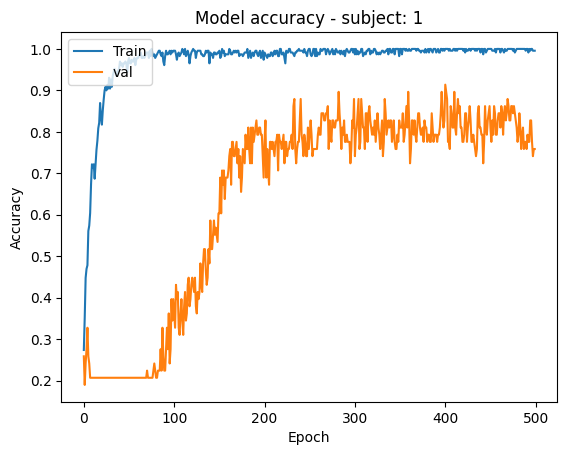

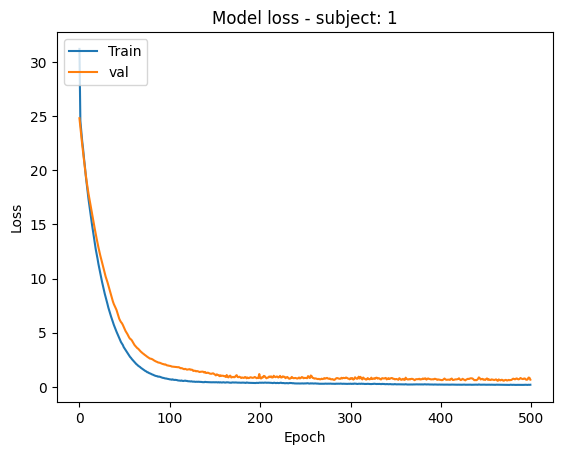


Training on subject  2
1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Subject: 2   seed 1   time: 6.6 m   valid_acc: 0.7931   valid_loss: 0.673
Plot Learning Curves ....... 


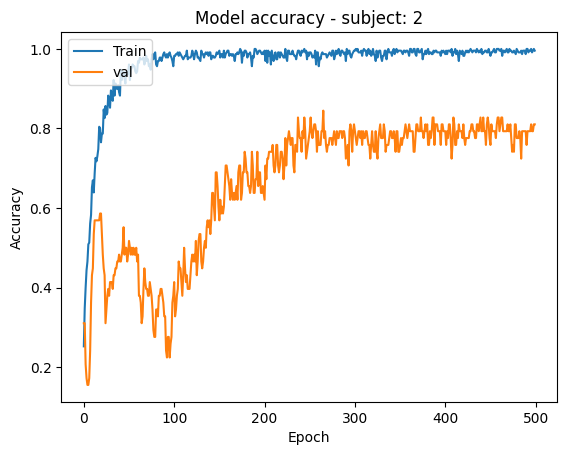

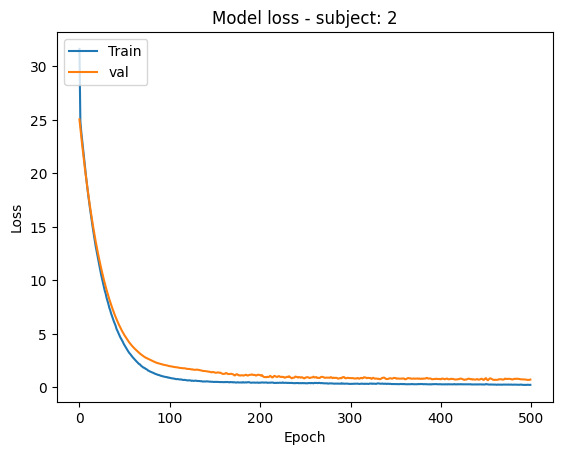


Training on subject  3


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Subject: 3   seed 1   time: 6.5 m   valid_acc: 0.8966   valid_loss: 0.415
Plot Learning Curves ....... 


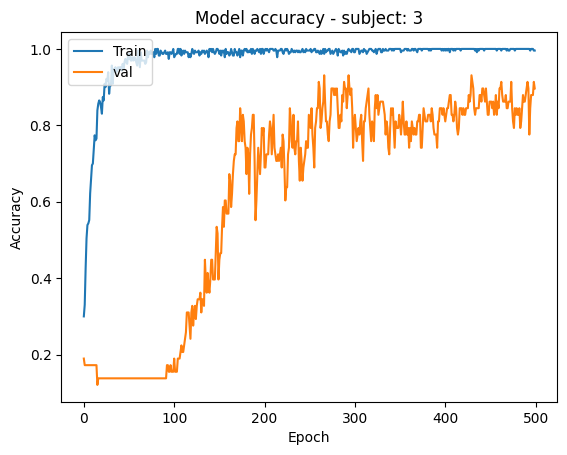

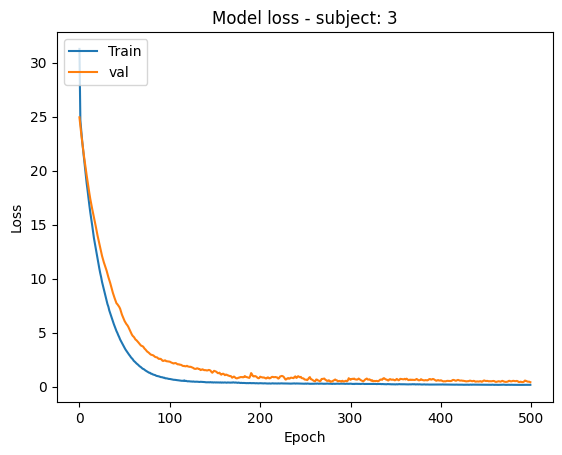


Training on subject  4
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Subject: 4   seed 1   time: 6.8 m   valid_acc: 0.8103   valid_loss: 0.757
Plot Learning Curves ....... 


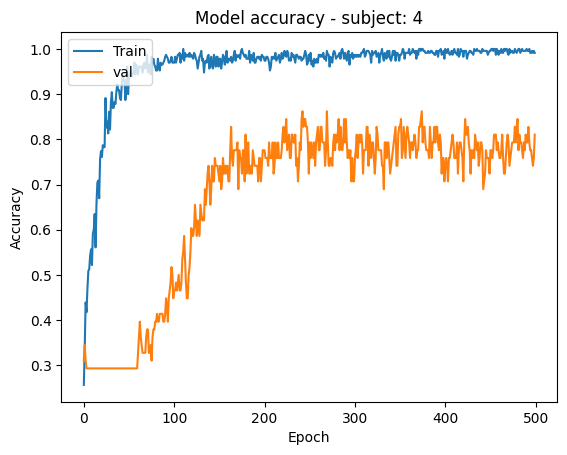

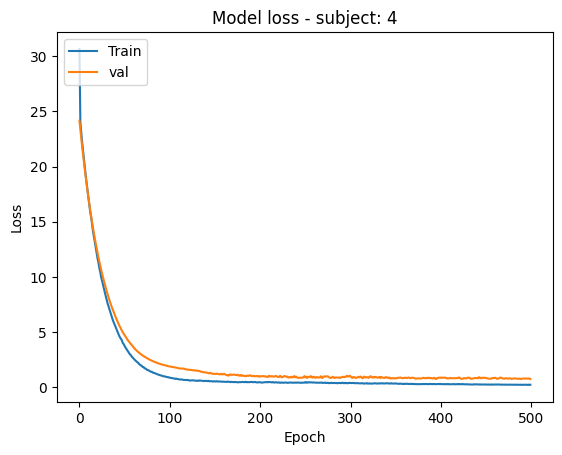


Training on subject  5
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Subject: 5   seed 1   time: 6.7 m   valid_acc: 0.8448   valid_loss: 0.572
Plot Learning Curves ....... 


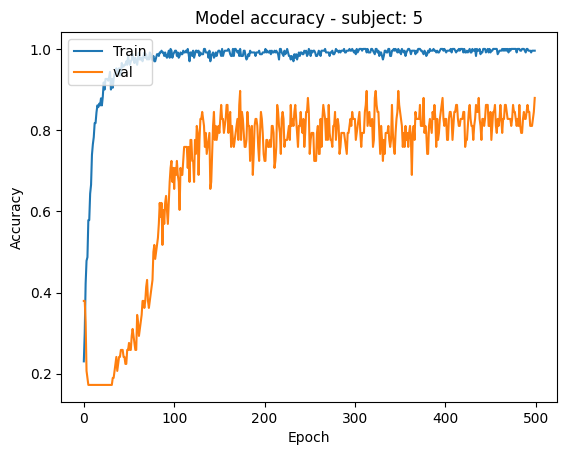

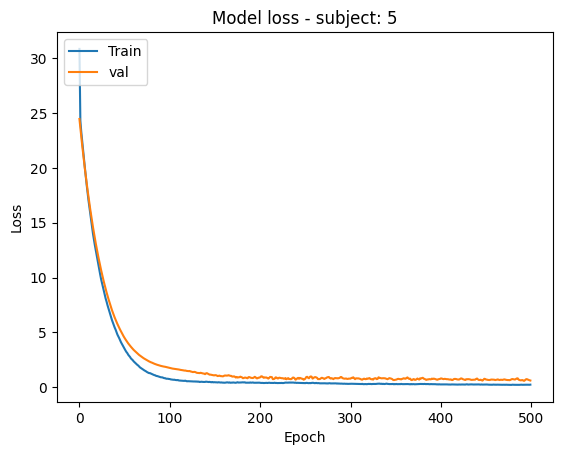


Training on subject  6
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Subject: 6   seed 1   time: 6.8 m   valid_acc: 0.8103   valid_loss: 0.686
Plot Learning Curves ....... 


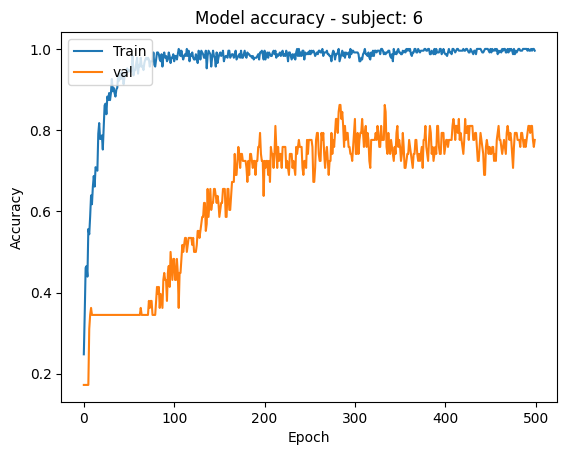

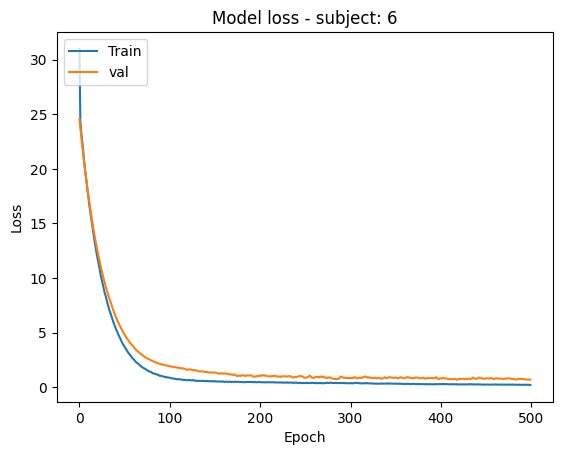


Training on subject  7
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step
Subject: 7   seed 1   time: 7.5 m   valid_acc: 0.9483   valid_loss: 0.296
Plot Learning Curves ....... 


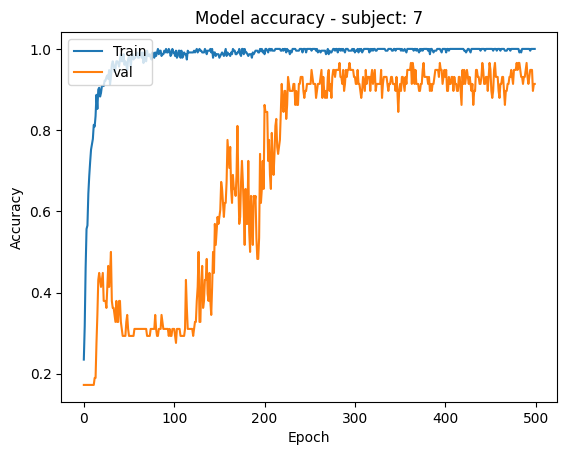

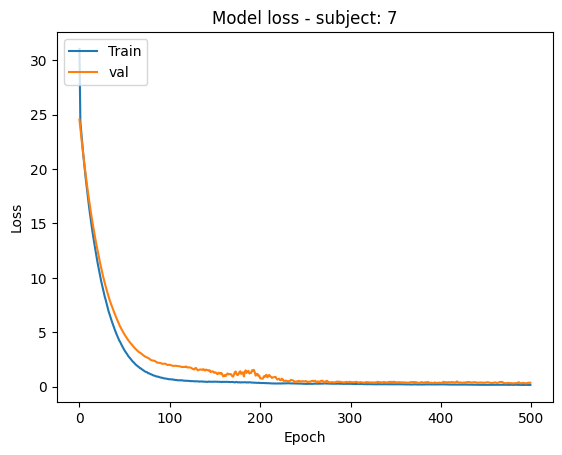


Training on subject  8
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Subject: 8   seed 1   time: 7.8 m   valid_acc: 0.9655   valid_loss: 0.243
Plot Learning Curves ....... 


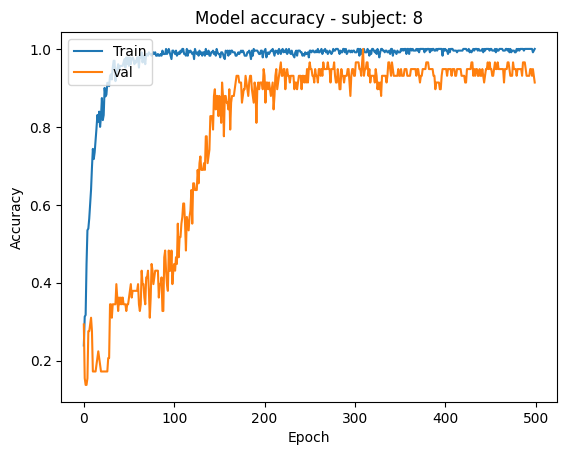

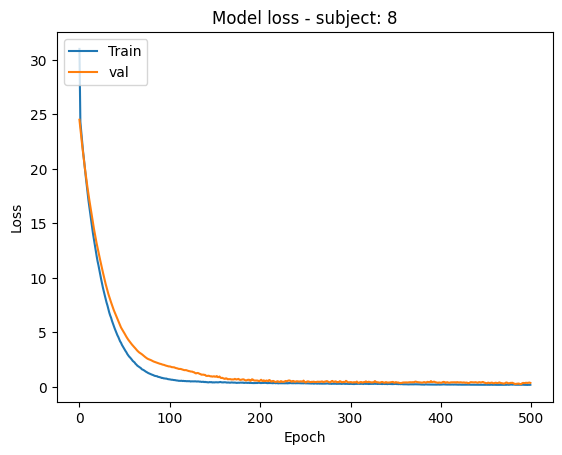


Training on subject  9
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
Subject: 9   seed 1   time: 8.3 m   valid_acc: 0.9828   valid_loss: 0.260
Plot Learning Curves ....... 


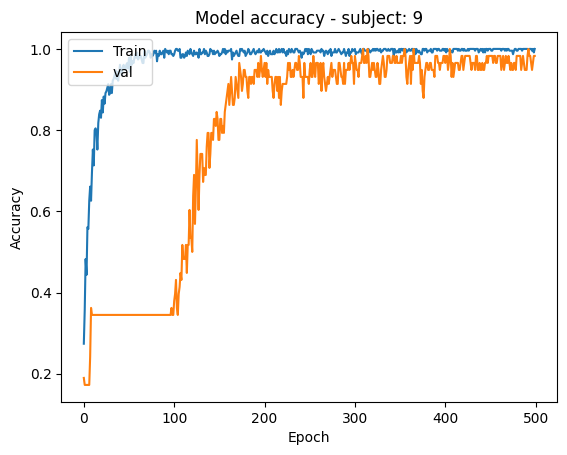

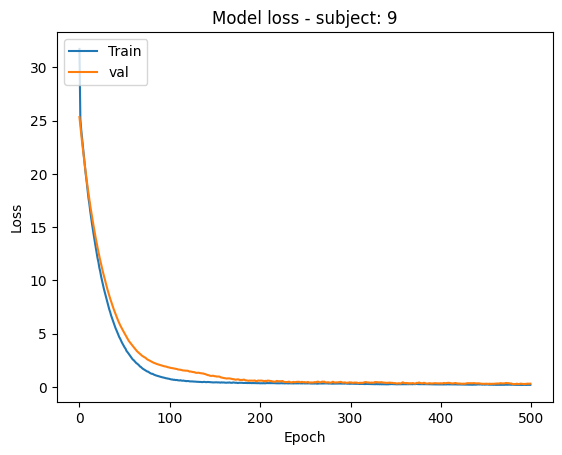


---------------------------------
Validation performance (acc %):
---------------------------------
         sub_1   sub_2   sub_3   sub_4   sub_5   sub_6   sub_7   sub_8   sub_9     average
         -----   -----   -----   -----   -----   -----   -----   -----   -----     -------
Seed 1:  84.48   79.31   89.66   81.03   84.48   81.03   94.83   96.55   98.28     87.74   
---------------------------------
Average acc - all seeds: 87.74 %

Train Time  - all seeds: 64.8 min
---------------------------------



FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/EEG-ATCNet/results/saved models/run-1/subject-1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [12]:
#%%
def draw_learning_curves(history, sub):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy - subject: ' + str(sub))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss - subject: ' + str(sub))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'val'], loc='upper left')
    plt.show()
    plt.close()

def draw_confusion_matrix(cf_matrix, sub, results_path, classes_labels):
    # Generate confusion matrix plot
    display_labels = classes_labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                                display_labels=display_labels)
    disp.plot()
    disp.ax_.set_xticklabels(display_labels, rotation=12)
    plt.title('Confusion Matrix of Subject: ' + sub )
    plt.savefig(results_path + '/subject_' + sub + '.png')
    plt.show()

def draw_performance_barChart(num_sub, metric, label):
    fig, ax = plt.subplots()
    x = list(range(1, num_sub+1))
    ax.bar(x, metric, 0.5, label=label)
    ax.set_ylabel(label)
    ax.set_xlabel("Subject")
    ax.set_xticks(x)
    ax.set_title('Model '+ label + ' per subject')
    ax.set_ylim([0,1])


#%% Training
def train(dataset_conf, train_conf, results_path):

    # remove the 'result' folder before training
    if os.path.exists(results_path):
        # Remove the folder and its contents
        shutil.rmtree(results_path)
        os.makedirs(results_path)

    # Get the current 'IN' time to calculate the overall training time
    in_exp = time.time()
    # Create a file to store the path of the best model among several runs
    best_models = open(results_path + "/best models.txt", "w")
    # Create a file to store performance during training
    log_write = open(results_path + "/log.txt", "w")

    # Get dataset parameters
    dataset = dataset_conf.get('name')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    # Get training hyperparamters
    batch_size = train_conf.get('batch_size')
    epochs = train_conf.get('epochs')
    patience = train_conf.get('patience')
    lr = train_conf.get('lr')
    LearnCurves = train_conf.get('LearnCurves') # Plot Learning Curves?
    n_train = train_conf.get('n_train')
    model_name = train_conf.get('model')
    from_logits = train_conf.get('from_logits')

    # Initialize variables
    acc = np.zeros((n_sub, n_train))
    kappa = np.zeros((n_sub, n_train))

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.

        print('\nTraining on subject ', sub+1)
        log_write.write( '\nTraining on subject '+ str(sub+1) +'\n')
        # Initiating variables to save the best subject accuracy among multiple runs.
        BestSubjAcc = 0
        bestTrainingHistory = []

        # Get training and validation data
        X_train, _, y_train_onehot, _, _, _ = get_data(
            data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        # Divide the training data into training and validation
        X_train, X_val, y_train_onehot, y_val_onehot = train_test_split(X_train, y_train_onehot, test_size=0.2, random_state=42)

        # Iteration over multiple runs
        for train in range(n_train): # How many repetitions of training for subject i.
            # Set the random seed for TensorFlow and NumPy random number generator.
            # The purpose of setting a seed is to ensure reproducibility in random operations.
            tf.random.set_seed(train+1)
            np.random.seed(train+1)

            # Get the current 'IN' time to calculate the 'run' training time
            in_run = time.time()

            # Create folders and files to save trained models for all runs
            filepath = results_path + '/saved models/run-{}'.format(train+1)
            if not os.path.exists(filepath):
                os.makedirs(filepath)
            filepath = filepath + '/subject-{}.weights.h5'.format(sub+1)

            # Create the model
            model = getModel(model_name, dataset_conf, from_logits)
            # Compile and train the model
            model.compile(loss=CategoricalCrossentropy(from_logits=from_logits), optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

            # model.summary()
            # plot_model(model, to_file='plot_model.png', show_shapes=True, show_layer_names=True)

            callbacks = [
                ModelCheckpoint(filepath, monitor='val_loss', verbose=0,
                                save_best_only=True, save_weights_only=True, mode='min'),
                ReduceLROnPlateau(monitor="val_loss", factor=0.90, patience=20, verbose=0, min_lr=0.0001),
                # EarlyStopping(monitor='val_loss', verbose=1, mode='min', patience=patience)
            ]
            history = model.fit(X_train, y_train_onehot, validation_data=(X_val, y_val_onehot),
                                epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=0)

            # Evaluate the performance of the trained model based on the validation data
            # Here we load the Trained weights from the file saved in the hard
            # disk, which should be the same as the weights of the current model.
            model.load_weights(filepath)
            y_pred = model.predict(X_val)

            if from_logits:
                y_pred = tf.nn.softmax(y_pred).numpy().argmax(axis=-1)
            else:
                y_pred = y_pred.argmax(axis=-1)

            labels = y_val_onehot.argmax(axis=-1)
            acc[sub, train]  = accuracy_score(labels, y_pred)
            kappa[sub, train] = cohen_kappa_score(labels, y_pred)

            # Get the current 'OUT' time to calculate the 'run' training time
            out_run = time.time()
            # Print & write performance measures for each run
            info = 'Subject: {}   seed {}   time: {:.1f} m   '.format(sub+1, train+1, ((out_run-in_run)/60))
            info = info + 'valid_acc: {:.4f}   valid_loss: {:.3f}'.format(acc[sub, train], min(history.history['val_loss']))
            print(info)
            log_write.write(info +'\n')
            # If current training run is better than previous runs, save the history.
            if(BestSubjAcc < acc[sub, train]):
                 BestSubjAcc = acc[sub, train]
                 bestTrainingHistory = history

        # Store the path of the best model among several runs
        best_run = np.argmax(acc[sub,:])
        filepath = '/saved models/run-{}/subject-{}.h5'.format(best_run+1, sub+1)+'\n'
        best_models.write(filepath)

        # Plot Learning curves
        if (LearnCurves == True):
            print('Plot Learning Curves ....... ')
            draw_learning_curves(bestTrainingHistory, sub+1)

    # Get the current 'OUT' time to calculate the overall training time
    out_exp = time.time()

    # Print & write the validation performance using all seeds
    head1 = head2 = '         '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n---------------------------------\nValidation performance (acc %):'
    info = info + '\n---------------------------------\n' + head1 +'\n'+ head2
    for run in range(n_train):
        info = info + '\nSeed {}:  '.format(run+1)
        for sub in range(n_sub):
            info = info + '{:.2f}   '.format(acc[sub, run]*100)
        info = info + '  {:.2f}   '.format(np.average(acc[:, run])*100)
    info = info + '\n---------------------------------\nAverage acc - all seeds: '
    info = info + '{:.2f} %\n\nTrain Time  - all seeds: {:.1f}'.format(np.average(acc)*100, (out_exp-in_exp)/(60))
    info = info + ' min\n---------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Close open files
    best_models.close()
    log_write.close()


#%% Evaluation
def test(model, dataset_conf, results_path, allRuns = True):
    # Open the  "Log" file to write the evaluation results
    log_write = open(results_path + "/log.txt", "a")

    # Get dataset paramters
    dataset = dataset_conf.get('name')
    n_classes = dataset_conf.get('n_classes')
    n_sub = dataset_conf.get('n_sub')
    data_path = dataset_conf.get('data_path')
    isStandard = dataset_conf.get('isStandard')
    LOSO = dataset_conf.get('LOSO')
    classes_labels = dataset_conf.get('cl_labels')

    # Test the performance based on several runs (seeds)
    runs = os.listdir(results_path+"/saved models")
    # Initialize variables
    acc = np.zeros((n_sub, len(runs)))
    kappa = np.zeros((n_sub, len(runs)))
    cf_matrix = np.zeros([n_sub, len(runs), n_classes, n_classes])

    # Iteration over subjects
    # for sub in range(n_sub-1, n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
    inference_time = 0 #  inference_time: classification time for one trial
    for sub in range(n_sub): # (num_sub): for all subjects, (i-1,i): for the ith subject.
        # Load data
        _, _, _, X_test, _, y_test_onehot = get_data(data_path, sub, dataset, LOSO = LOSO, isStandard = isStandard)

        # Iteration over runs (seeds)
        for seed in range(len(runs)):
            # Load the model of the seed.
            model.load_weights('{}/saved models/{}/subject-{}.h5'.format(results_path, runs[seed], sub+1))

            inference_time = time.time()
            # Predict MI task
            y_pred = model.predict(X_test).argmax(axis=-1)
            inference_time = (time.time() - inference_time)/X_test.shape[0]
            # Calculate accuracy and K-score
            labels = y_test_onehot.argmax(axis=-1)
            acc[sub, seed]  = accuracy_score(labels, y_pred)
            kappa[sub, seed] = cohen_kappa_score(labels, y_pred)
            # Calculate and draw confusion matrix
            cf_matrix[sub, seed, :, :] = confusion_matrix(labels, y_pred, normalize='true')
            # draw_confusion_matrix(cf_matrix[sub, seed, :, :], str(sub+1), results_path, classes_labels)

    # Print & write the average performance measures for all subjects
    head1 = head2 = '                  '
    for sub in range(n_sub):
        head1 = head1 + 'sub_{}   '.format(sub+1)
        head2 = head2 + '-----   '
    head1 = head1 + '  average'
    head2 = head2 + '  -------'
    info = '\n' + head1 +'\n'+ head2
    info = '\n---------------------------------\nTest performance (acc & k-score):\n'
    info = info + '---------------------------------\n' + head1 +'\n'+ head2
    for run in range(len(runs)):
        info = info + '\nSeed {}: '.format(run+1)
        info_acc = '(acc %)   '
        info_k = '        (k-sco)   '
        for sub in range(n_sub):
            info_acc = info_acc + '{:.2f}   '.format(acc[sub, run]*100)
            info_k = info_k + '{:.3f}   '.format(kappa[sub, run])
        info_acc = info_acc + '  {:.2f}   '.format(np.average(acc[:, run])*100)
        info_k = info_k + '  {:.3f}   '.format(np.average(kappa[:, run]))
        info = info + info_acc + '\n' + info_k
    info = info + '\n----------------------------------\nAverage - all seeds (acc %): '
    info = info + '{:.2f}\n                    (k-sco): '.format(np.average(acc)*100)
    info = info + '{:.3f}\n\nInference time: {:.2f}'.format(np.average(kappa), inference_time * 1000)
    info = info + ' ms per trial\n----------------------------------\n'
    print(info)
    log_write.write(info+'\n')

    # Draw a performance bar chart for all subjects
    draw_performance_barChart(n_sub, acc.mean(1), 'Accuracy')
    draw_performance_barChart(n_sub, kappa.mean(1), 'k-score')
    # Draw confusion matrix for all subjects (average)
    draw_confusion_matrix(cf_matrix.mean((0,1)), 'All', results_path, classes_labels)
    # Close opened file
    log_write.close()


#%%
def getModel(model_name, dataset_conf, from_logits = False):

    n_classes = dataset_conf.get('n_classes')
    n_channels = dataset_conf.get('n_channels')
    in_samples = dataset_conf.get('in_samples')

    # Select the model
    if(model_name == 'RockNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.RockNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.5,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 64,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'ATCNet'):
        # Train using the proposed ATCNet model: https://ieeexplore.ieee.org/document/9852687
        model = models.ATCNet_(
            # Dataset parameters
            n_classes = n_classes,
            in_chans = n_channels,
            in_samples = in_samples,
            # Sliding window (SW) parameter
            n_windows = 5,
            # Attention (AT) block parameter
            attention = 'mha', # Options: None, 'mha','mhla', 'cbam', 'se'
            # Convolutional (CV) block parameters
            eegn_F1 = 16,
            eegn_D = 2,
            eegn_kernelSize = 64,
            eegn_poolSize = 7,
            eegn_dropout = 0.3,
            # Temporal convolutional (TC) block parameters
            tcn_depth = 2,
            tcn_kernelSize = 4,
            tcn_filters = 32,
            tcn_dropout = 0.3,
            tcn_activation='elu',
            )
    elif(model_name == 'TCNet_Fusion'):
        # Train using TCNet_Fusion: https://doi.org/10.1016/j.bspc.2021.102826
        model = models.TCNet_Fusion(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGTCNet'):
        # Train using EEGTCNet: https://arxiv.org/abs/2006.00622
        model = models.EEGTCNet(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNet'):
        # Train using EEGNet: https://arxiv.org/abs/1611.08024
        model = models.EEGNet_classifier(n_classes = n_classes, Chans=n_channels, Samples=in_samples)
    elif(model_name == 'EEGNeX'):
        # Train using EEGNeX: https://arxiv.org/abs/2207.12369
        model = models.EEGNeX_8_32(n_timesteps = in_samples , n_features = n_channels, n_outputs = n_classes)
    elif(model_name == 'DeepConvNet'):
        # Train using DeepConvNet: https://doi.org/10.1002/hbm.23730
        model = models.DeepConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'ShallowConvNet'):
        # Train using ShallowConvNet: https://doi.org/10.1002/hbm.23730
        model = models.ShallowConvNet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)
    elif(model_name == 'MBEEG_SENet'):
        # Train using MBEEG_SENet: https://www.mdpi.com/2075-4418/12/4/995
        model = models.MBEEG_SENet(nb_classes = n_classes , Chans = n_channels, Samples = in_samples)

    else:
        raise Exception("'{}' model is not supported yet!".format(model_name))

    return model

#%%
def run():
    # Define dataset parameters
    dataset = 'BCI2a' # Options: 'BCI2a','HGD', 'CS2R'

    if dataset == 'BCI2a':
        in_samples = 1125
        n_channels = 22
        n_sub = 9
        n_classes = 4
        classes_labels = ['Left hand', 'Right hand','Foot','Tongue']
        data_path = 'dataset/' #os.path.expanduser('~') + '/BCI Competition IV/BCI Competition IV-2a/BCI Competition IV 2a mat/'
    elif dataset == 'HGD':
        in_samples = 1125
        n_channels = 44
        n_sub = 14
        n_classes = 4
        classes_labels = ['Right Hand', 'Left Hand','Rest','Feet']
        data_path = os.path.expanduser('~') + '/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/'
    elif dataset == 'CS2R':
        in_samples = 1125
        # in_samples = 576
        n_channels = 32
        n_sub = 18
        n_classes = 3
        # classes_labels = ['Fingers', 'Wrist','Elbow','Rest']
        classes_labels = ['Fingers', 'Wrist','Elbow']
        # classes_labels = ['Fingers', 'Elbow']
        data_path = os.path.expanduser('~') + '/CS2R MI EEG dataset/all/EDF - Cleaned - phase one (remove extra runs)/two sessions/'
    else:
        raise Exception("'{}' dataset is not supported yet!".format(dataset))

    # Create a folder to store the results of the experiment
    results_path = os.getcwd() + "/results"
    if not  os.path.exists(results_path):
      os.makedirs(results_path)   # Create a new directory if it does not exist

    # Set dataset paramters
    dataset_conf = { 'name': dataset, 'n_classes': n_classes, 'cl_labels': classes_labels,
                    'n_sub': n_sub, 'n_channels': n_channels, 'in_samples': in_samples,
                    'data_path': data_path, 'isStandard': True, 'LOSO': False}
    # Set training hyperparamters
    train_conf = { 'batch_size': 64, 'epochs': 500, 'patience': 100, 'lr': 0.001,'n_train': 1,
                  'LearnCurves': True, 'from_logits': False, 'model':'RockNet'}

    # Train the model
    train(dataset_conf, train_conf, results_path)

    # Evaluate the model based on the weights saved in the '/results' folder
    model = getModel(train_conf.get('model'), dataset_conf)
    test(model, dataset_conf, results_path)

#%%
if __name__ == "__main__":
    run()
